## Asset Allocation Problem

Consider the Stochastic Cake Eating Problem covered in class. Suppose that instead of investing the wealth entirely in the stock market, you have the option to assign a fraction  α  of your wealth in the stock market, and the remaining is invested in a risk-free savings account that pays a 1.04 % gross return. Notice that  α  is bounded below by 0, and bounded above by 1.

Solve for the optimal consumption ( c ) and asset allocation ( α ).

Print the average sum of discounted rewards (utilities) using 1 million simulations.

Plot the average consumption-wealth ratio ( c/x)  for each time period  t=0,1,...,299

Plot the average asset allocation in the risky asset( α)  for each time period  t=0,1,...,299

# Groupmembers:
Junru Wang, junruw2\
Tianyang Luo, tluo11\
Bohan Li, bohanli5\
Ruohao Huang, ruohaoh2

In [ ]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn

# Constants
γ = 2.0
β = 0.95
T = 300
x0 = 10.0
Rf = 1.04
batch_size = 10000 # Ensure this is constant at compile time
learning_rate = -1e-3

# Utility function
def u(c):
    return (c + 1e-8) ** (1 - γ) / (1 - γ)

# Consumption function
def c(theta, x):
    return theta * x

# Stock return simulation
def stock_return(rng):
    μs = 0.06
    σs = 0.2
    ε = jax.random.normal(rng, ())
    log_return = μs + σs * ε
    return jnp.exp(log_return)


def sigmoid_inverse(x):
    return jnp.log(x / (1 - x))


# Neural network model
class AlphaThetaModel(nn.Module):
    @nn.compact
    def __call__(self, x_input, t_input):
        inputs = jnp.concatenate([x_input, t_input], axis=-1)
        x = nn.Dense(64)(inputs)
        x = nn.silu(x)
        x = nn.Dense(128)(x)
        x = nn.silu(x)

        desired_cx_init = 0.01
        desired_alpha_init = 0.5
        bias_init_values = sigmoid_inverse(jnp.array([desired_cx_init, desired_alpha_init]))
        outputs = nn.Dense(2, bias_init=nn.initializers.constant(bias_init_values))(x)
        # outputs = nn.Dense(2)(x)
        outputs = nn.sigmoid(outputs)
        return outputs


# Normalization function
def normalize(x, x_max):
    return x / (x_max)  # Add smoothing to avoid abrupt changes

# Loss function
def L(params, apply_fn, rng, batch_size):
    def one_simulation(rng):
        x = x0
        x_max = x0  # Initialize x_max with the starting wealth
        V = 0.0
        carry = x, x_max, V, rng

        def core(carry, t):
            x, x_max, V, rng = carry
            rng = jax.random.split(rng)[0]

            # Update x_max dynamically
            # x_max = jnp.maximum(x, x_max)

            # Normalize x to [0, 1]
            # x_norm = normalize(x, x_max)

            x_input = jnp.array([[x/x0]])
            t_input = jnp.array([[t/T]])

            # Get alpha_t and theta_t from the model
            predictions = apply_fn(params, x_input, t_input)
            theta_t, alpha_t, = predictions.squeeze()

            # theta_t = jax.lax.cond(
            #     t == T - 1,
            #     lambda _: jnp.float32(1),
            #     lambda _: theta_t,
            #     operand=None
            # )
            # Wealth update

            R = stock_return(rng)
            x = x * (alpha_t * R + (1 - alpha_t) * Rf)
            # Compute consumption and utility
            c_t = c(theta_t, x)
            ut = u(c_t)
            V = V + ut * β**t
            x = x - c_t
            #from jax import debug
            #debug.print("Time {t}: x = {x}, r = {R}, alpha={alpha}", t=t, x=x,R=R, alpha=alpha_t)
            return (x, x_max, V, rng), (theta_t, alpha_t, x, c_t)

        (x, x_max, V, rng), (theta, alpha, x, c_t) = jax.lax.scan(core, carry, jnp.arange(T))
        return V, (theta, alpha, x, c_t)

    rng_n = jax.random.split(rng, batch_size)
    V, (theta, alpha, x, c_t) = jax.vmap(one_simulation)(rng_n)

    # Regularization
    time_weight = jnp.arange(T)  # Weight increases linearly with t/T
    reg_theta = jnp.mean((theta - 1) ** 2 * time_weight)  # Penalize theta deviation, weighted by time
    reg_asset = jnp.mean(x ** 2 * time_weight)  # Penalize asset allocation, weighted by time

    regularization = 0.01*(reg_theta + reg_asset)  # Tune regularization weight
    return V.mean() - regularization , (theta.mean(axis=0), alpha.mean(axis=0), x.mean(axis=0), c_t.mean(axis=0))

# Optimizer update step
def update(params, opt_state, rng, batch_size):
    def loss_fn(p):
        return L(p, apply_fn, rng, batch_size)

    (loss, aux), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    rng = jax.random.split(rng)[0]
    return params, opt_state, loss, aux, grads, rng



In [ ]:
# Use jax.jit with static_argnums explicitly
update = jax.jit(update, static_argnums=(3))  # batch_size is now static

# Initialize the model
model = AlphaThetaModel()
rng = jax.random.PRNGKey(0)
init_rng, rng = jax.random.split(rng)
x_input_init = jnp.array([[1]])
t_input_init = jnp.array([[0.0]])
params = model.init(init_rng, x_input_init, t_input_init)  # Initialize model parameters
apply_fn = model.apply

# Optimizer setup
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Training loop
for i in range(1000):
    params, opt_state, loss, (theta, alpha, x, c_t), grads, rng = update(params, opt_state, rng, batch_size)

    # Convert or summarize arrays appropriately for printing
    loss_scalar = loss.item() if loss.size == 1 else loss.mean().item()
    theta_mean = theta.mean() if theta.ndim > 0 else theta.item()
    alpha_mean = alpha.mean() if alpha.ndim > 0 else alpha.item()

    # Example: Inspect the gradient of the first layer weights
    grad_first_layer = grads["params"]["Dense_0"]["kernel"]  # Adjust based on your parameter names
    grad_norm = jnp.linalg.norm(grad_first_layer)

    if i % 100 == 0:
        print(f"Iteration {i}: Loss = {loss_scalar:.4f}, theta mean = {theta_mean:.4f}, alpha mean = {alpha_mean:.4f}")
        print(f"Gradient norm (first layer): {grad_norm:.4f}")

# Final evaluation
V, (theta_final, a_final, x_final, c_final) = L(params, apply_fn, rng, batch_size=100000)
print(f"Average sum of discounted rewards (utilities): {V:.4f}")

Iteration 0: Loss = -4757.4839, theta mean = 0.0448, alpha mean = 0.3853
Gradient norm (first layer): 10767.7002
Iteration 100: Loss = -60.0433, theta mean = 0.0599, alpha mean = 0.3497
Gradient norm (first layer): 7.7349
Iteration 200: Loss = -54.0244, theta mean = 0.0748, alpha mean = 0.3274
Gradient norm (first layer): 4.8630
Iteration 300: Loss = -52.0158, theta mean = 0.0853, alpha mean = 0.3127
Gradient norm (first layer): 2.5821
Iteration 400: Loss = -51.8116, theta mean = 0.0839, alpha mean = 0.3042
Gradient norm (first layer): 2.9648
Iteration 500: Loss = -50.1853, theta mean = 0.0830, alpha mean = 0.2916
Gradient norm (first layer): 2.4149
Iteration 600: Loss = -49.6193, theta mean = 0.0815, alpha mean = 0.2829
Gradient norm (first layer): 2.2824
Iteration 700: Loss = -48.1575, theta mean = 0.0795, alpha mean = 0.2784
Gradient norm (first layer): 1.1958
Iteration 800: Loss = -49.9548, theta mean = 0.0763, alpha mean = 0.2793
Gradient norm (first layer): 1.3988
Iteration 900: 

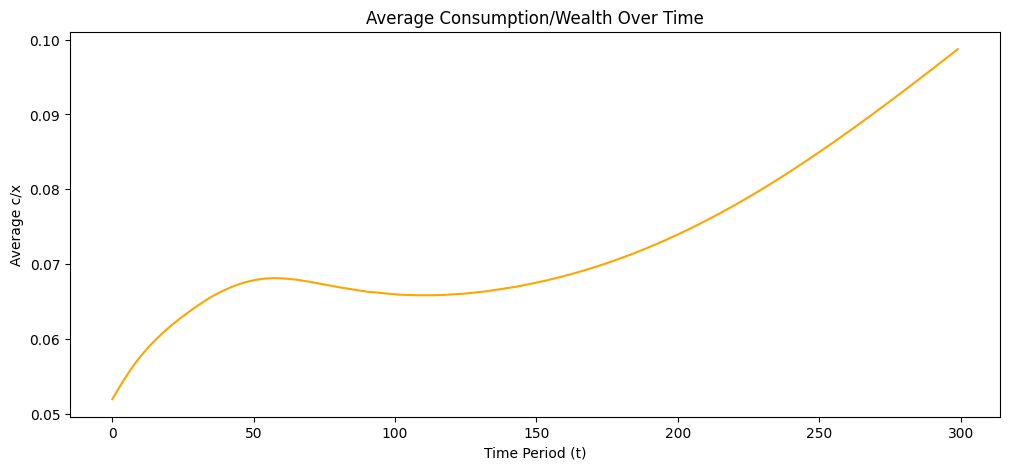

In [ ]:
import matplotlib.pyplot as plt

# Plot average asset allocation over time
plt.figure(figsize=(12, 5))
plt.plot(theta_final, color="orange")
plt.xlabel("Time Period (t)")
plt.ylabel("Average c/x")
plt.title("Average Consumption/Wealth Over Time")
plt.show()

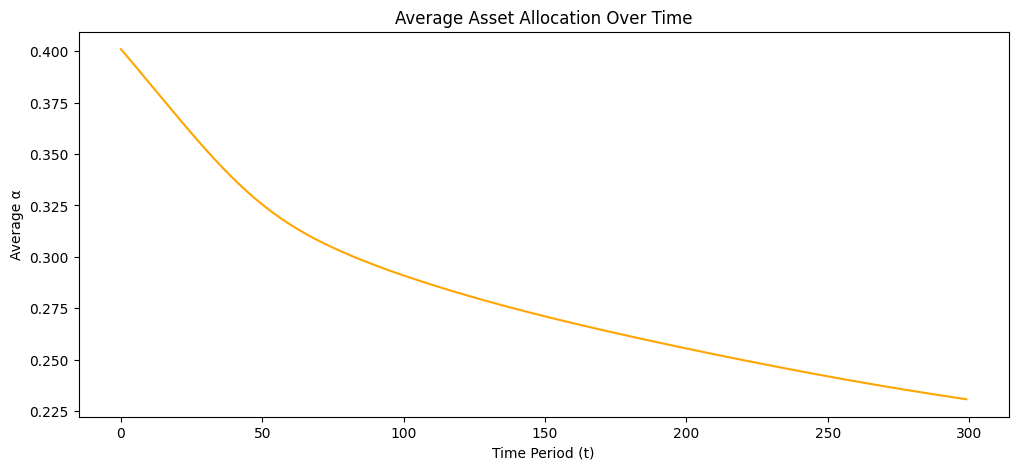

In [ ]:
# Plot average asset allocation over time
plt.figure(figsize=(12, 5))
plt.plot(a_final, color="orange")
plt.xlabel("Time Period (t)")
plt.ylabel("Average α")
plt.title("Average Asset Allocation Over Time")
plt.show()

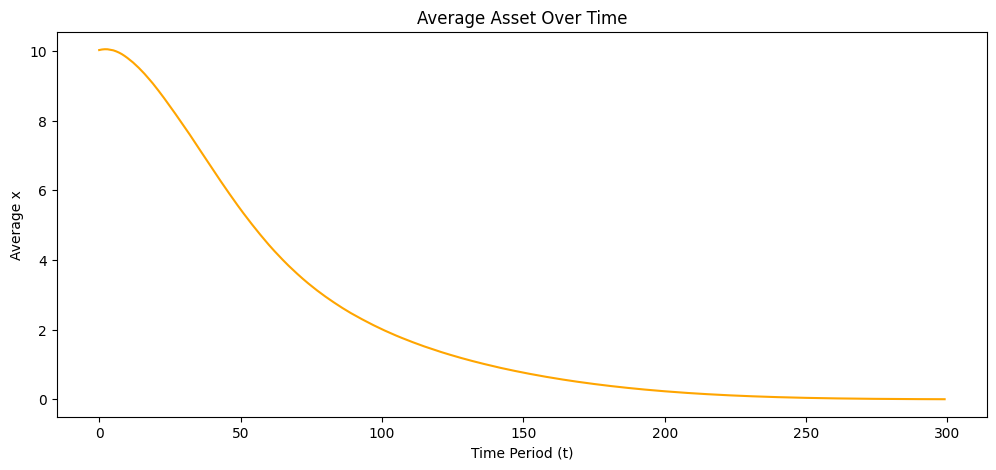

In [ ]:
# Plot average asset allocation over time
plt.figure(figsize=(12, 5))
plt.plot(x_final, color="orange")
plt.xlabel("Time Period (t)")
plt.ylabel("Average x")
plt.title("Average Asset Over Time")
plt.show()

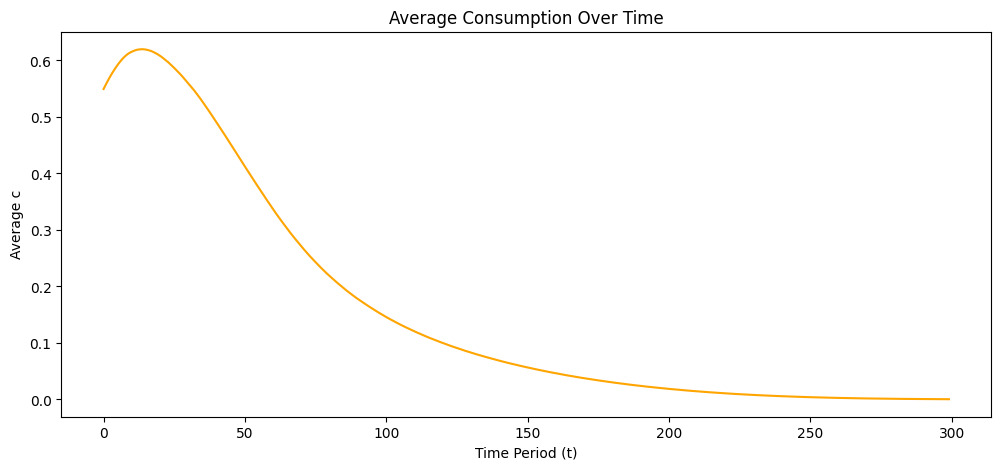

In [ ]:
# Plot average asset allocation over time
plt.figure(figsize=(12, 5))
plt.plot(c_final, color="orange")
plt.xlabel("Time Period (t)")
plt.ylabel("Average c")
plt.title("Average Consumption Over Time")
plt.show()